# Verification experiment - NARMAX

In [38]:
using Revise
using ProgressMeter
using LinearAlgebra
using JLD
using MAT
using Plots
pyplot();

include("experiments_NARMAX.jl");

gen_combs (generic function with 1 method)

## Data

We generate data according to a NARMAX system.

### Experimental parameters

In [37]:
# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:64) .+ transient

# Length of testing signal
ix_tst = collect(1:1000) .+ transient

# Number of VMP iterations
num_iters = 5;

### System parameters

In [3]:
# # Polynomial degrees
# deg_t = 3

# # True orders
# M1_t = 3
# M2_t = 3
# M3_t = 3
# M_t = M1_t + 1 + M2_t + M3_t

# # Number of coefficients
# N_t = M_t*deg_t + 1

# # True basis function
# PΨ = zeros(M_t,0); for d=1:deg_t; PΨ = hcat(d .*Matrix{Float64}(I,M_t,M_t), PΨ); end
# ψ(x::Array{Float64,1}) = [prod(x.^PΨ[:,k]) for k = 1:size(PΨ,2)];

# # Parameters
# τ_true = 1e6
# θ_true = .5 .*(rand(N_t,) .- 0.5);
# θ_true[end] = 0.;

### Generate input

In [4]:
# include("fMultiSinGen.jl")

# # Parameters
# num_periods = 10
# points_period = 1000
# num_real = 1
# fMin = 0.0
# fMax = 100.0
# fs = 10 .* fMax
# uStd = 0.1

# # Input frequency and amplitude
# input, inputfreq = fMultiSinGen(points_period, 
#                                 num_periods, 
#                                 num_real, 
#                                 fMin=fMin, 
#                                 fMax=fMax, 
#                                 fs=fs, 
#                                 type_signal="odd", 
#                                 uStd=uStd);

# # Scale down
# # input /= 10.;

In [5]:
# plot(input, color="red", label="input")

In [6]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [7]:
# ix_zoom = 100:300
# plot(ix_zoom, input[ix_zoom], color="red", label="input", xlabel="time [k]", ylabel="signal")

In [8]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom100-300.png")

### Generate output

In [9]:
# # Observation array
# output = zeros(T,)
# errors = zeros(T,)

# for k = 1:T

#     # Generate noise
#     errors[k] = sqrt(inv(τ_true))*randn(1)[1]

#     # Output
#     if k < (maximum([M1_t, M2_t, M3_t])+1)
#         output[k] = input[k] + errors[k]
#     else
#         # Update history vectors
#         x_kmin1 = output[k-1:-1:k-M1_t]
#         z_kmin1 = input[k-1:-1:k-M2_t]
#         r_kmin1 = errors[k-1:-1:k-M3_t]

#         # Compute output
#         output[k] = θ_true'*ψ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
#     end
# end

# # Y-Limits of output signal
# ylims = [minimum(output[tt:T]), maximum(output[tt:T])];

In [10]:
# plot(output[tt:T], color="black", label="output")

In [11]:
# savefig("figures/NARMAX-generated-output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [12]:
# plot(input[tt:T], color="red", label="input")
# plot!(output[tt:T], color="black", label="output")

In [13]:
# savefig("figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [14]:
# # Visualize signal
# zoom_t = 200:400
# p101 = plot(zoom_t, input[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="", size=(600,220))
# plot!(zoom_t, output[zoom_t], color="black", label="output", legend=:topleft)

In [15]:
# savefig(p101, "figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom200-400.png")

### Model parameters

In [39]:
# Polynomial degree
deg_m = 3;

# Model orders
M1_m = 1
M2_m = 1
M3_m = 1
M_m = 1 + M1_m + M2_m + M3_m

options = Dict("na" => M1_m,
               "nb" => M2_m,
               "ne" => M3_m,
               "nd" => deg_m,
               "dc" => false,
               "crossTerms" => true,
               "noiseCrossTerms" => true)

# Model basis function
# PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
PΦ = gen_combs(options)
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

# Number of coefficients after basis expansion
N_m = size(PΦ,2)

55

In [40]:
PΦ

5×55 Array{Float64,2}:
 1.0  2.0  3.0  0.0  1.0  2.0  0.0  1.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  2.0  2.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  2.0  2.0  2.0  2.0  2.0  3.0

### Load matlab code

In [4]:
mat_data = matread("data/NARMAXsignal_order4_r1.mat")
input_trn = mat_data["uTrain"][ix_trn]
input_tst = mat_data["uTest"][ix_tst]
output_trn = mat_data["yTrain"][ix_trn]
output_tst = mat_data["yTest"][ix_tst];

θ_true = mat_data["theta"]
τ_true = inv(mat_data["options"]["stde"].^2);

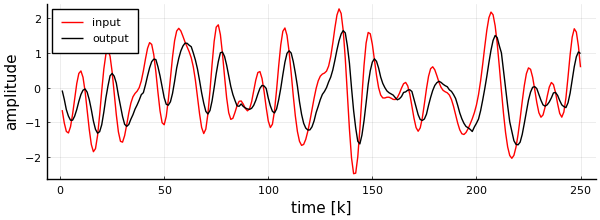

In [5]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_trn[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, output_trn[zoom_t], color="black", label="output")

In [19]:
savefig("figures/NARMAX-generated-input+output_deg"*string(deg_m)*"_order"*string(M_m)*"_zoom"*string(zoom_t[1])*"-"*string(zoom_t[end])*".png")

## Free Energy Minimisation

In [6]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafePrecision
using NARMAX

┌ Info: Precompiling NARMAX [f7e2066e-04e0-49c5-b905-b27976d9dac0]
└ @ Base loading.jl:1278


In [25]:
graph = FactorGraph()

# Observed variables
@RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1_m,))
@RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2_m,))
@RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3_m,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N_m,)), placeholder(:w_θ, dims=(N_m, N_m)))

# Model basis function
PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

### Estimate parameters

In [26]:
# Initialize priors
θ_k = (rand(N_m,) .- .5, 1. .*Matrix{Float64}(I,N_m,N_m))
τ_k = (1e3, 1e0);

In [27]:
# Maximum delay
maxM = maximum([M1_m, M2_m, M3_m])

# Zero-padding of signals
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

# Signal splits
T_trn = length(input_trn)
T_tst = length(input_tst)

"Inference execution"

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,N_m), zeros(T_trn-maxM,N_m,N_m))
params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

# Preallocate prediction arrays
predictions_FEM = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1_m]
    y_kmin1 = output_trn[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions_FEM[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :u_kmin1 => u_kmin1,
                :y_kmin1 => y_kmin1,
                :e_kmin1 => e_kmin1,
                :m_θ => θ_k[1],
                :w_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
#         Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [28]:
errors

517-element Array{Float64,1}:
   0.0
   0.2917520041265207
   0.06015861230651266
  -0.00256653301915934
   0.000848467167997189
   0.2852192280480039
  -0.8089035399284084
  -0.2504132648426414
   0.07145478239598102
  -0.04522809699047703
  -0.033907036550094194
  -1.3446933497463363
  58.95188854349021
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

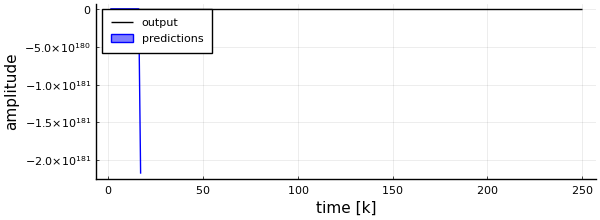

In [29]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, output_trn[zoom_t], color="black", label="output", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="predictions", legend=:topleft)

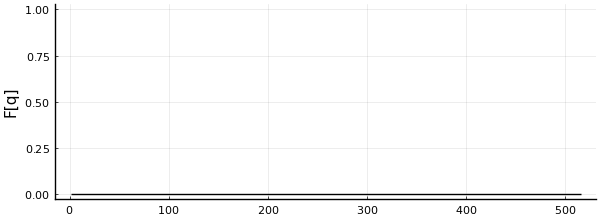

In [30]:
plot(Fq[:,end], color="black", ylabel="F[q]", label="", size=(600,220))

In [31]:
# save("results/FE-NARMAX_FEM_M"*string(M_m)*"_degree"*string(deg_m)*"_S"*string(ts-tt)*".jld", "FE", Fq)

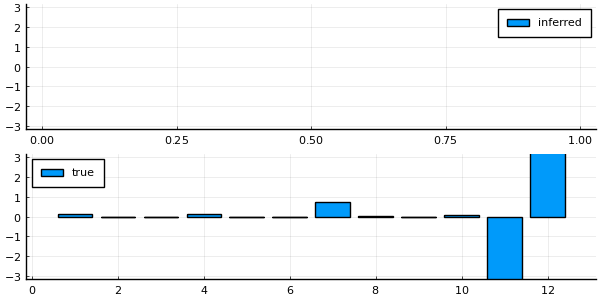

In [32]:
p55a = bar(θ_k[1], label="inferred", ylims=[-3.,3.])
p55b = bar(θ_true, label="true", ylims=[-3.,3.])
p55 = plot(p55a, p55b, layout=(2,1), size=(600,300))

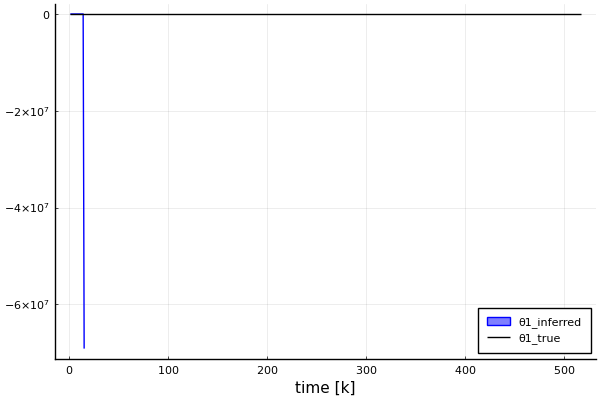

In [33]:
sdθ1 = sqrt.(inv.(params_θ[2][:,1,1]))
plot(params_θ[1][:,1], ribbon=[sdθ1 sdθ1], color="blue", xlabel="time [k]", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn,), color="black", label="θ1_true")

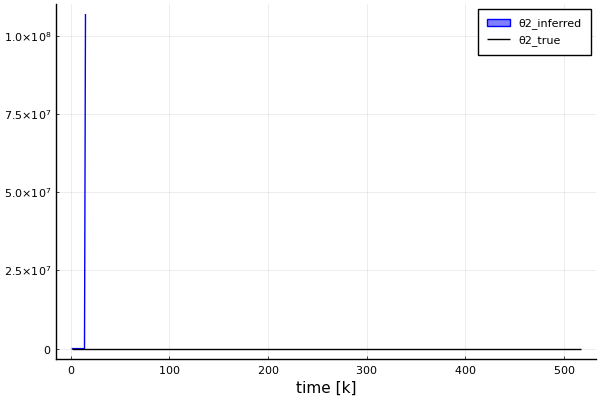

In [34]:
sdθ2 = sqrt.(inv.(params_θ[2][:,2,2]))
plot(params_θ[1][:,2], ribbon=[sdθ2 sdθ2], color="blue", xlabel="time [k]", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn,), color="black", label="θ2_true")

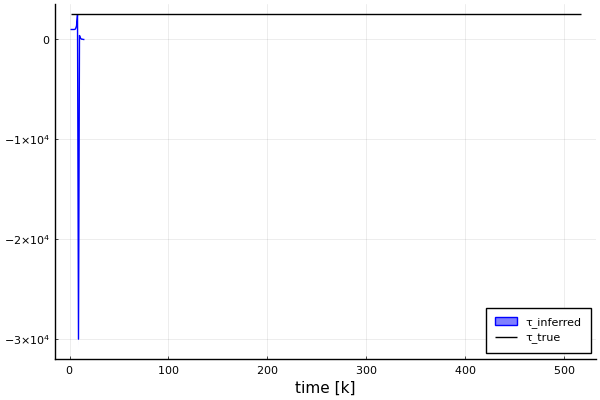

In [35]:
mτ = params_τ[1] ./ params_τ[2]
sτ = sqrt.(params_τ[1] ./ params_τ[2].^2)

plot(mτ, ribbon=[sτ sτ], color="blue", xlabel="time [k]", label="τ_inferred")
plot!(τ_true*ones(T_trn,), color="black", label="τ_true")

### 1-step ahead prediction error

In [31]:
predictions_FEM = (zeros(T_tst,), zeros(T_tst,))
errors = zeros(T_tst,)

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1_m]
    y_kmin1 = output_tst[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])

    # Update error
    errors[k] = output_tst[k] - predictions_FEM[1][k]

end

# Compute root mean square error
RMS_prd_FEM = sqrt(mean((predictions_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

0.032105969265526065

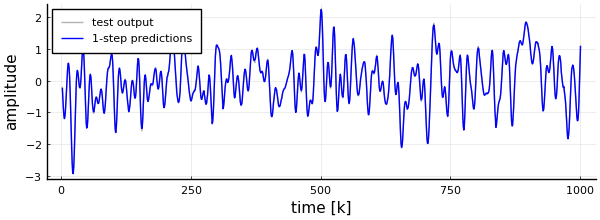

In [32]:
zoom_t = maxM+1:T_tst
p150 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, predictions_FEM[1][zoom_t], color="blue", label="1-step predictions")
# plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="1-step predictions")

In [33]:
savefig(p150, "figures/NARMAX-1steppredictions_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

### Simulation error

In [34]:
simulations_FEM = (zeros(T_tst,), zeros(T_tst,))

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1_m]
    y_kmin1 = simulations_FEM[1][k-1:-1:k-M2_m]
    e_kmin1 = zeros(M3_m,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

end

# Compute root mean squared error
RMS_sim_FEM = sqrt(mean((simulations_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

0.05210771934770308

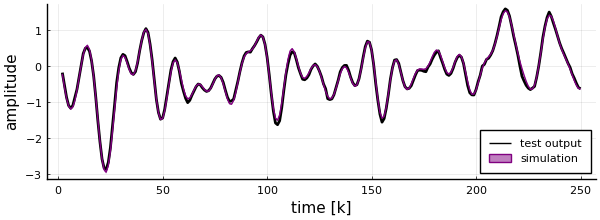

In [35]:
zoom_t = maxM+1:250
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=2, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, simulations_FEM[1][zoom_t], ribbon=[sqrt.(simulations_FEM[2][zoom_t]), sqrt.(simulations_FEM[2][zoom_t])], color="purple", label="simulation")

In [36]:
savefig(p210, "figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

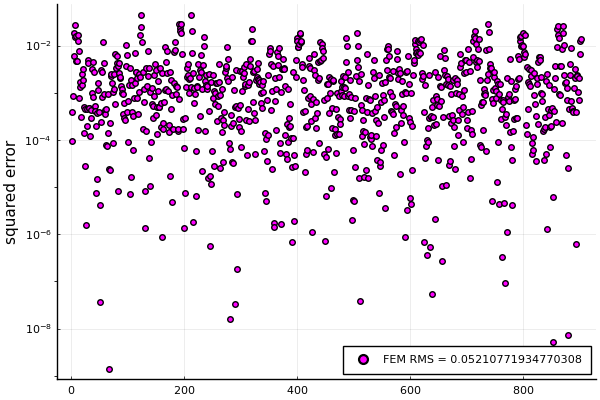

In [37]:
sim_transient = 100
sqerror_sim_FEM = (simulations_FEM[1][sim_transient:end] .- output_tst[sim_transient:end]).^2

scatter(sqerror_sim_FEM, label="FEM RMS = "*string(RMS_sim_FEM), color="magenta", ylabel="squared error", yscale=:log10)

## Baseline: Recursive Least-Squares

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [38]:
# Forgetting factor
λ = 1.00

# Initialize
P = λ.*Matrix{Float64}(I,N_m,N_m)
w_k = zeros(N_m,)

# Preallocate prediction array
predictions_RLS = zeros(T_trn,)
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update data vector
    u_kmin1 = input_trn[k-1:-1:k-M1_m]
    y_kmin1 = output_trn[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]
    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])

    # Update weights
    α = output_trn[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    errors[k] = output_trn[k] - predictions_RLS[k]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


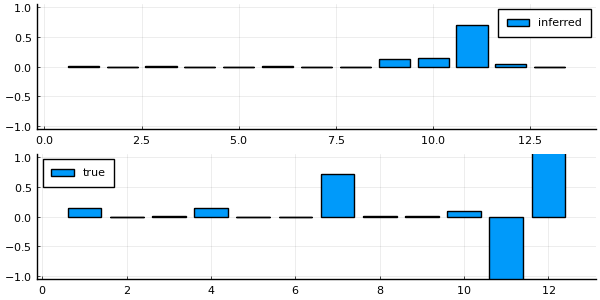

In [53]:
p55a = bar(w_k, label="inferred", ylims=[-1., 1.])
p55b = bar(θ_true, label="true", ylims=[-1., 1.])
p55 = plot(p55a, p55b, layout=(2,1), size=(600,300))

### 1-step ahead prediction error

In [40]:
predictions_RLS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1_m]
    y_kmin1 = output_tst[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    # Point prediction
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_RLS[k] = w_k'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_RLS[k]

end

RMS_prd_RLS = sqrt(mean((predictions_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.033526297872557266

### Simulation error

In [41]:
simulations_RLS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1_m]
    y_kmin1 = simulations_RLS[k-1:-1:k-M2_m]
    e_kmin1 = zeros(M3_m,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_RLS[k] = w_k'*ϕx

end

RMS_sim_RLS = sqrt(mean((simulations_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.06873057244408225

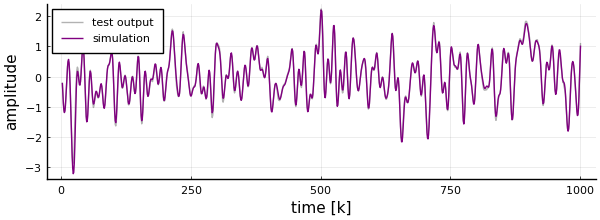

In [42]:
zoom_t = maxM+1:T_tst
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, simulations_RLS[zoom_t], color="purple", label="simulation")

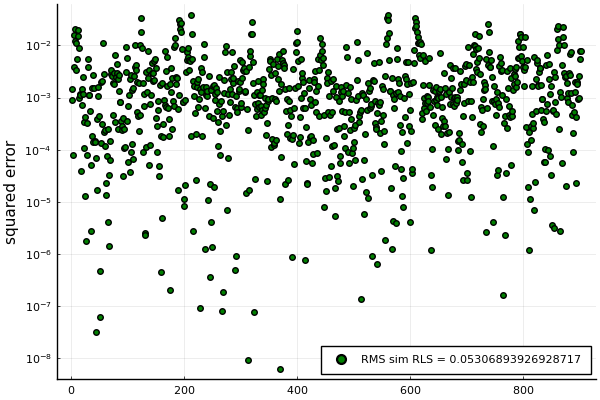

In [56]:
sim_transient = 100
sqerror_sim_RLS = (simulations_RLS[sim_transient:end] .- output_tst[sim_transient:end]).^2

scatter(sqerror_sim_RLS, label="RMS sim RLS = "*string(RMS_sim_RLS), color="green", ylabel="squared error", yscale=:log10)

## Baseline: Iterative Least-Squares

In [57]:
results_ILS = matread("results/results-NARMAX_ILS_M"*string(M_m)*"_degree3_r1.mat")
RMS_prd_ILS = results_ILS["RMS_prd"][2]
RMS_sim_ILS = results_ILS["RMS_sim"][2]

0.08586739702688158

## Comparisons

In [58]:
transient_sim = 100
sqerror_sim_FEM = (simulations_FEM[1][transient_sim:T_tst] - output_tst[transient_sim:T_tst]).^2
sqerror_sim_RLS = (simulations_RLS[transient_sim:T_tst] - output_tst[transient_sim:T_tst]).^2

RMS_sim_FEM = sqrt(mean(sqerror_sim_FEM))
RMS_sim_RLS = sqrt(mean(sqerror_sim_RLS))

println("RMS sim FEM = "*string(RMS_sim_FEM))
println("RMS sim RLS = "*string(RMS_sim_RLS))
println("RMS sim ILS = "*string(RMS_sim_ILS))

RMS sim FEM = 0.05266603194777312
RMS sim RLS = 0.05306893926928717
RMS sim ILS = 0.08586739702688158


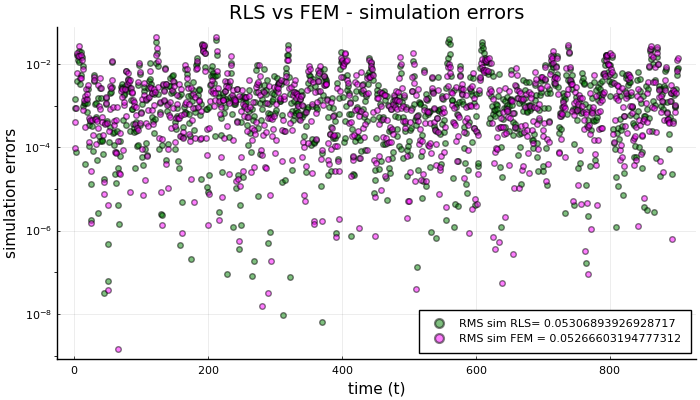

In [59]:
# Comparing simulation errors between PEM and FEM
scatter(sqerror_sim_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RMS sim RLS= "*string(RMS_sim_RLS))
scatter!(sqerror_sim_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="RMS sim FEM = "*string(RMS_sim_FEM),
         title="RLS vs FEM - simulation errors")

In [60]:
savefig("figures/NARMAX-errors_deg"*string(deg_m)*"_order"*string(M_m)*".png")

In [61]:
prop_beaten = mean(sqerror_sim_FEM .< sqerror_sim_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 49.0%


In [62]:
transient_prd = 100
sqerror_prd_FEM = (predictions_FEM[1][transient_prd:T_tst] - output_tst[transient_prd:T_tst]).^2
sqerror_prd_RLS = (predictions_RLS[transient_prd:T_tst] - output_tst[transient_prd:T_tst]).^2

RMS_prd_FEM = sqrt(mean(sqerror_prd_FEM))
RMS_prd_RLS = sqrt(mean(sqerror_prd_RLS))

println("RMS prd FEM = "*string(RMS_prd_FEM))
println("RMS prd RLS = "*string(RMS_prd_RLS))
println("RMS prd ILS = "*string(RMS_prd_ILS))

RMS prd FEM = 0.03273575582749071
RMS prd RLS = 0.03296479052138112
RMS prd ILS = NaN


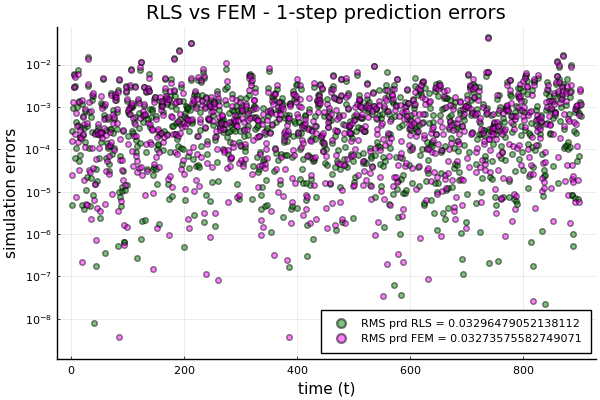

In [63]:
# Comparing simulation errors between PEM and FEM
scatter(sqerror_prd_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
#         size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RMS prd RLS = "*string(RMS_prd_RLS))
scatter!(sqerror_prd_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="RMS prd FEM = "*string(RMS_prd_FEM),
         title="RLS vs FEM - 1-step prediction errors")

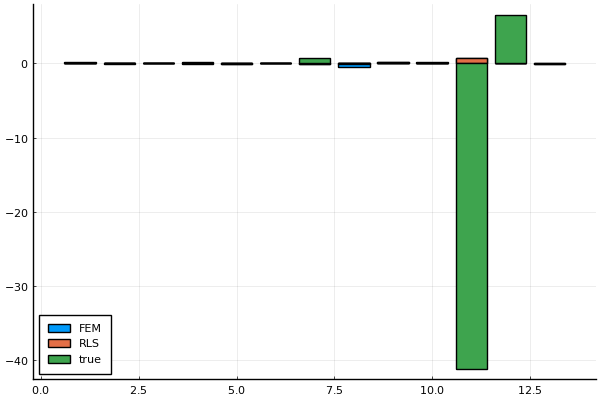

In [51]:
bar(θ_k[1], label="FEM")
bar!(w_k, label="RLS")
bar!(θ_true, label="true")